Tässä notebookissa tehdään Silver-tason prosessoinnit datalle, eli ladataan bronze_pipeline.ipynb ETL-putken luomat lopputulokset ja otetaan data esikäsittellyyn. Esikäsittelyssä data putsataan ja prosessoidaan haluttuun muotoon. Tämän jälkeen data tallennetaan Gold-tason tauluun, joka toimii datan lopullisena tallennuspaikkana, josta sitä käytetään tämän projektin muissa välivaiheissa.

In [1]:
!pip install duckdb


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData_lite" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬──────────────────────────────────┬───────┬───────┬───────┬───────┐
│ node_id │            timestamp             │   x   │   y   │   z   │   q   │
│  int32  │             varchar              │ int32 │ int32 │ int32 │ int32 │
├─────────┼──────────────────────────────────┼───────┼───────┼───────┼───────┤
│    3200 │ 2019-03-07 11:46:19.078016+00:00 │     0 │     0 │     0 │    51 │
│    3200 │ 2019-03-07 11:46:20.078012+00:00 │     0 │     0 │     0 │   163 │
│    3200 │ 2019-03-07 11:46:21.078081+00:00 │     0 │     0 │     0 │    42 │
│    3200 │ 2019-03-07 11:46:22.07813+00:00  │     0 │     0 │     0 │   105 │
│    3200 │ 2019-03-13 15:29:43.686639+00:00 │   -50 │    50 │     0 │   106 │
│    3200 │ 2019-03-13 15:29:44.686592+00:00 │   -50 │    50 │     0 │    76 │
│    3200 │ 2019-03-13 15:29:45.686654+00:00 │   -50 │    50 │     0 │    68 │
│    3200 │ 2019-03-13 15:29:46.686785+00:00 │   -50 │    50 │     0 │   142 │
│    3200 │ 2019-03-13 15:29:47.687715+00:00 │   -50

In [3]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData_lite" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
df = conn.sql(f"SELECT * FROM {table_name}").df() # Tallenentaan taulun data Pandasin dataframeen
conn.close()

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978588 entries, 0 to 12978587
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
 4   z          int32 
 5   q          int32 
dtypes: int32(5), object(1)
memory usage: 346.6+ MB


In [ ]:
# Tehdään perus EDA (Explorative Data Analysis)
!pip install ydata-profiling
!pip install setuptools

In [ ]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

#Tätä ei kannata ajaa koko datasetille, koska kestää ajallisesti tosi pitkään.
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("data_raportti.html")

In [5]:
# Tässä prosessoinnin vaiheessa poistetaan Z & Q sarakkeet

df = df.drop(columns=['z', 'q'])

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978588 entries, 0 to 12978587
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
dtypes: int32(3), object(1)
memory usage: 247.5+ MB


In [6]:
# Tässä prosessoinnin vaiheessa laitetaan oikea tietotyyppi timestamp sarakkeelle (datetime)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df.info(verbose=True)
print(df.head(n=10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978588 entries, 0 to 12978587
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 247.5 MB
   node_id                        timestamp   x   y
0     3200 2019-03-07 11:46:19.078016+00:00   0   0
1     3200 2019-03-07 11:46:20.078012+00:00   0   0
2     3200 2019-03-07 11:46:21.078081+00:00   0   0
3     3200 2019-03-07 11:46:22.078130+00:00   0   0
4     3200 2019-03-13 15:29:43.686639+00:00 -50  50
5     3200 2019-03-13 15:29:44.686592+00:00 -50  50
6     3200 2019-03-13 15:29:45.686654+00:00 -50  50
7     3200 2019-03-13 15:29:46.686785+00:00 -50  50
8     3200 2019-03-13 15:29:47.687715+00:00 -50  50
9     3200 2019-03-13 15:29:48.686671+00:00 -50  50


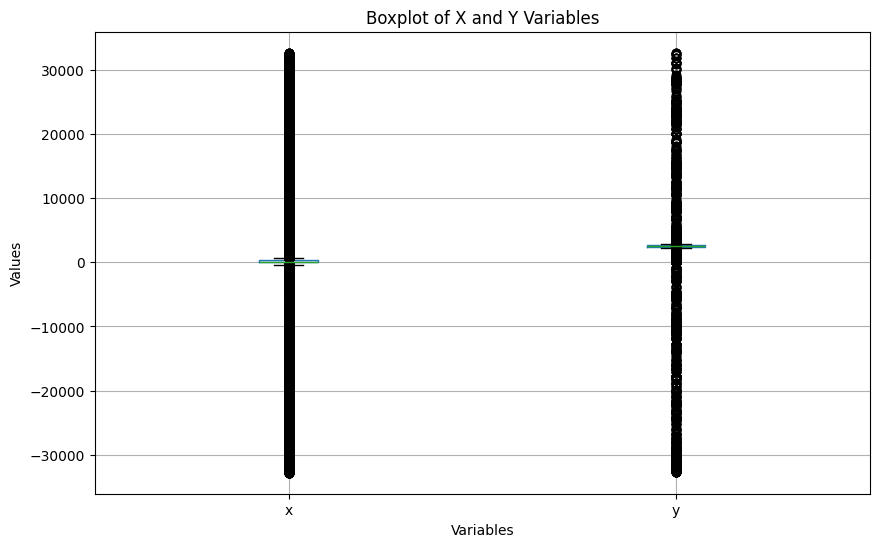

          node_id             x             y
count  12978588.0  1.297859e+07  1.297859e+07
mean       3200.0  7.801438e+02  2.594087e+03
std           0.0  1.977286e+03  7.415937e+02
min        3200.0 -3.281800e+04 -3.270500e+04
25%        3200.0  4.600000e+01  2.453000e+03
50%        3200.0  1.320000e+02  2.536000e+03
75%        3200.0  3.130000e+02  2.642000e+03
max        3200.0  3.265500e+04  3.270600e+04


In [7]:
# Tarkastellaan ja poistetaan Outlierit
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 12970242 entries, 0 to 12978587
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 346.3 MB


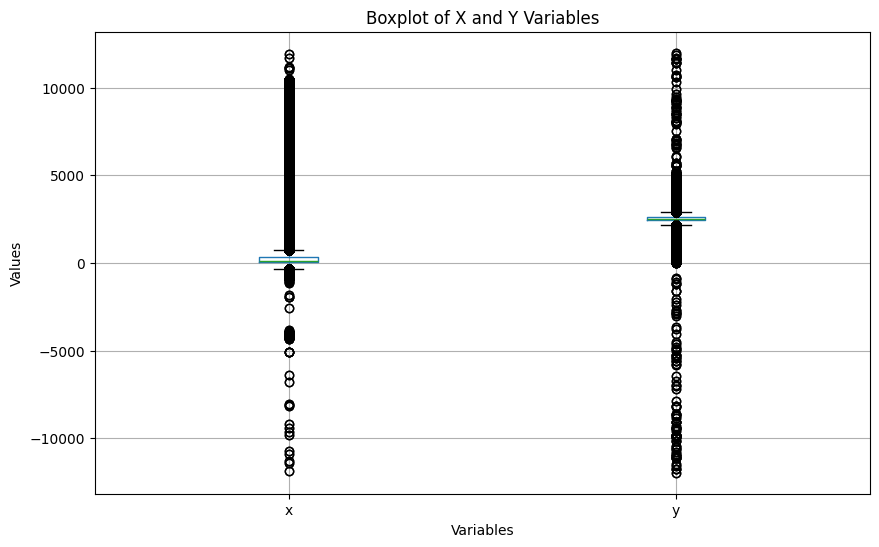

In [8]:
# Tarkastellaan ja poistetaan Outlierit

# Määritellään ylä ja alarajat X-akselissa TODO: määrittele tarkemmin
lower_bound_X = -12000
upper_bound_X = 12000


# Määritellään ylä ja alarajat y-akselissa TODO: määrittele tarkemmin
lower_bound_Y = -12000
upper_bound_Y = 12000

# Filteröidään pois
outliers_X = df[(df['x'] < lower_bound_X) | (df['x'] > upper_bound_X)]
outliers_Y = df[(df['y'] < lower_bound_Y) | (df['y'] > upper_bound_Y)]


# Poistetaan outlierit
df = df[~df.index.isin(outliers_X.index) & ~df.index.isin(outliers_Y.index)]

df.info(verbose=True)


import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

In [ ]:
# Onko jotain muuta?

In [9]:
from functions.database import create_db_table
from functions.database import insert_dataframe_into_table
#from functions.database import drop_table
# Tallennetaan dataframe silver tauluun

table_name = "Silver_SensorData_lite" # tai Silver_SensorData
duckdb_path = "data/duckdb.database"
schema = f'''
        CREATE TABLE {table_name} (
        node_id INTEGER NOT NULL,
        timestamp TIMESTAMP,
        x INTEGER NOT NULL,
        y INTEGER NOT NULL,
        )
        '''

#drop_table(database=duckdb_path, table_name=table_name) # Poista kommentti, jos tarvitsee poistaa tietokantataulu
create_db_table(database=duckdb_path, table_name=table_name,schema=schema) # Luodaan tietokantataulu
insert_dataframe_into_table(database=duckdb_path, table_name=table_name, df=df, insert=True) # Lisätään dataframe tietokantatauluun (Insert, eli lisätään rivejä vanhan perään)



Silver_SensorData_lite on jo olemassa
Tallennetaan dataframe tietokantaan, jonka muoto on: (12970242, 4)
Tallennus tauluun Silver_SensorData_lite onnistui


In [10]:
# Tarkistetaan, miltä luotu taulu näyttää:
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬────────────────────────────┬───────┬───────┐
│ node_id │         timestamp          │   x   │   y   │
│  int32  │         timestamp          │ int32 │ int32 │
├─────────┼────────────────────────────┼───────┼───────┤
│    3200 │ 2019-03-07 13:46:19.078016 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:20.078012 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:21.078081 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:22.07813  │     0 │     0 │
│    3200 │ 2019-03-13 17:29:43.686639 │   -50 │    50 │
│    3200 │ 2019-03-13 17:29:44.686592 │   -50 │    50 │
│    3200 │ 2019-03-13 17:29:45.686654 │   -50 │    50 │
│    3200 │ 2019-03-13 17:29:46.686785 │   -50 │    50 │
│    3200 │ 2019-03-13 17:29:47.687715 │   -50 │    50 │
│    3200 │ 2019-03-13 17:29:48.686671 │   -50 │    50 │
│      ·  │             ·              │     · │     · │
│      ·  │             ·              │     · │     · │
│      ·  │             ·              │     · │     · │
│    3200 │ 2019-03-13 20:16:18